In [ ]:
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 19.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')


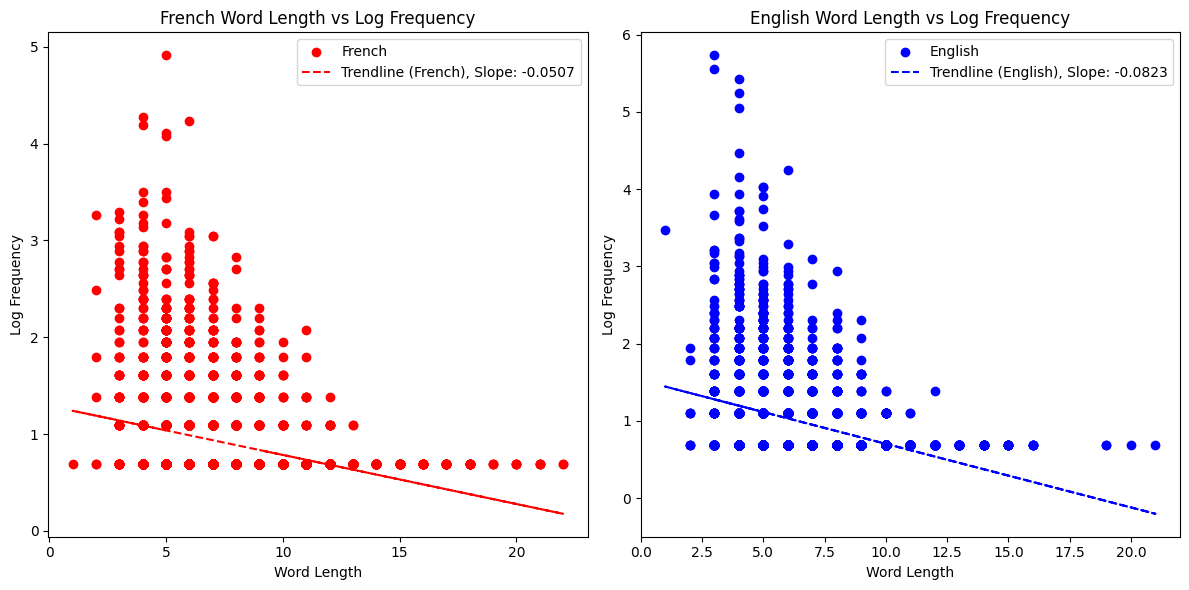

In [ ]:
#EXERCISE 1
import urllib.request           # to open/read URLs
import spacy                    # to process and tokenize text
import re                       # to parse text with regular expressions
from bs4 import BeautifulSoup   # to parse text and cleanup html tags
import pandas as pd             # to create dataframes out of tokens pulled from the texts
from collections import Counter # to store objects of the dataframes as keys and count them as values
import matplotlib.pyplot as plt # to plot and create diagrams out of the data collected
import numpy as np              # to calculate logarithm of the frequency values and to calculate and manipulate coefficients in the plot

en_book_url = 'https://www.gutenberg.org/cache/epub/1041/pg1041.txt'   # URL of EN book we want to read in
fr_book_url = 'https://www.gutenberg.org/cache/epub/27191/pg27191.txt' # URL of FR book we want to read in

en_book_text = urllib.request.urlopen(en_book_url) # Open EN book URL as "en_book_text"
en_book_text = en_book_text.read()                 # Returns all bytes from "en_book_text"
en_book_text = en_book_text.decode("utf-8")        # Decode as UTF-8

fr_book_text = urllib.request.urlopen(fr_book_url) # Open FR book URL as "fr_book_text"
fr_book_text = fr_book_text.read()                 # Returns all bytes from "fr_book_text"
fr_book_text = fr_book_text.decode("utf-8")        # Decode as UTF-8

# Text processing with spaCy
nlp_en = spacy.load("en_core_web_sm")   # Create nlp object for English text with en_core_web_sm trained pipeline
nlp_fr = spacy.load("fr_core_news_sm")  # Create nlp object for French text with fr_core_news_sm trained pipeline
token_en = nlp_en(en_book_text)         # Process and tokenize English text with spaCy
token_fr = nlp_fr(fr_book_text)         # Process and tokenize French text with spaCy

# Identify the beginning and the end of the English book, removing what is before and after
en_text=token_en.text
index_begin=en_text.index("From fairest")
index_end=en_text.index("*** END OF THE PROJECT GUTENBERG EBOOK SHAKESPEARE'S SONNETS ***")
en=en_text[index_begin:index_end]

# Identify the beginning and the end the French book, removing what is before and after
fr_text=token_fr.text
index_begin=fr_text.index("Nous désirons")
index_end=fr_text.index("FIN.")
fr=fr_text[index_begin:index_end]

# Parse French text to remove any HTML tags
fr_no_html = BeautifulSoup(fr)
fr = fr_no_html.get_text()

# Define a regular expression pattern to match Roman numeral chapter numbers and replace them with blank spaces.
# The multiline flags ensure that the regex pattern is applied to each new line in the text.
en_final = re.sub('^[IVXLCDM]+\s*.$', '', en, flags=re.MULTILINE)
fr_final = re.sub('^[IVXLCDM]+\s*.$', '', fr, flags=re.MULTILINE)

# Function to clean text from unwanted patterns
def clean_text(text):
    cleaned_text = re.sub(r'[\r\n]+', '', text) # Replace occurrences of new lines or carriage returns with blanks
    return cleaned_text.strip()                 # Return text free from leading and trailing whitespaces

# Apply clean_text function to both texts
cleaned_fr_final = clean_text(fr_final)
cleaned_en_final = clean_text(en_final)

# Re-tokenize cleaned texts
token_en_final = nlp_en(cleaned_en_final)
token_fr_final = nlp_fr(cleaned_fr_final)

# Define a function to create dataframes with relevant tokens
def process_text(doc):
  words=[(token.text.lower(), len(token.text)) for token in doc if not token.is_stop and not token.is_punct] # Create a list of tuples made of qualifying tokens (i.e. words) and their respective length in characters, ignoring case and filtering out stopwords and punctuation.
  frq = Counter(word[0] for word in words)                                                                   # Get frequency of each unique word
  df = pd.DataFrame(list(frq.items()), columns=['word', 'frequency'])                                        # Create a dataframe with words and their respective frequency
  df['length'] = df['word'].apply(len)                                                                       # Use apply function to count the length of each word in the dataframe
  df = df.sort_values(by='frequency', ascending=False).reset_index(drop=True)                                # Sort words in df by frequency, in descending order
  return df

# Apply function to the tokenized texts to get dataframes for both languages
df_fr=process_text(token_fr_final)
df_en=process_text(token_en_final)

# Define function to calculate log frequency with Laplace smoothing in order to improve generalization and probability estimation
def calculate_log_frequency(df):
    df['log_frequency'] = np.log(df['frequency'] + 1)
    return df

# Apply log frequency function to both languages dataframes
df_fr = calculate_log_frequency(df_fr)
df_en = calculate_log_frequency(df_en)

# Define function to add trendline and slope to the plots representing the dataframes
def plot_trendline(ax, x, y, color, label):
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), color=color, linestyle='--', label=f'Trendline ({label}), Slope: {z[0]:.4f}')

# Plotting word length vs log frequency with Laplace smoothing for both languages with trendlines
plt.figure(figsize=(12, 6)) # Define plot size
  # Plot for French data
plt.subplot(1, 2, 1)
plt.scatter(df_fr['length'], df_fr['log_frequency'], color='r', marker='o', label='French')
plot_trendline(plt.gca(), df_fr['length'], df_fr['log_frequency'], 'r', 'French')
  # Add labels, title and legend to the French plot
plt.xlabel('Word Length')
plt.ylabel('Log Frequency')
plt.title('French Word Length vs Log Frequency')
plt.legend()

  # Plot for English data
plt.subplot(1, 2, 2)
plt.scatter(df_en['length'], df_en['log_frequency'], color='b', marker='o', label='English')
plot_trendline(plt.gca(), df_en['length'], df_en['log_frequency'], 'b', 'English')
  # Add labels, title and legend to the English plot
plt.xlabel('Word Length')
plt.ylabel('Log Frequency')
plt.title('English Word Length vs Log Frequency')
plt.legend()

plt.tight_layout()
plt.show()
